<a href="https://colab.research.google.com/github/NimraAkram321/data/blob/main/fireDectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [2]:
!git clone https://github.com/NimraAkram321/data

Cloning into 'data'...
remote: Enumerating objects: 107, done.
remote: Total 107 (delta 0), reused 0 (delta 0), pack-reused 107
Receiving objects: 100% (107/107), 66.99 MiB | 21.13 MiB/s, done.


In [3]:
import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:

import cv2
from scipy.stats import uniform

In [5]:

from tqdm import tqdm
from glob import glob

In [6]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking


In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [8]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


In [9]:
#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

cp: cannot stat '../input/keras-pretrained-models/xception*': No such file or directory


In [10]:
base_folder = '/content/data'
data_folder = '/content/data'
train_data_folder = '/content/data/fire_img'
test_date_folder  = '/content/data/non_fire_img'


In [11]:
categories = ['fire_img', 'non_fire_img']
len_categories = len(categories)


In [12]:
image_count = {}
train_data = []

In [13]:
for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])


2it [00:00, 2733.34it/s]


In [14]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_img -> 50
non_fire_img -> 50


In [15]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(100, 3)

,file,id,label
0,fire_img/fire.137.png,0,fire_img
1,fire_img/fire.111.png,0,fire_img
2,fire_img/fire.141.png,0,fire_img
3,fire_img/fire.105.png,0,fire_img
4,fire_img/fire.132.png,0,fire_img


In [16]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask


In [17]:
#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

In [18]:
#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [19]:
# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

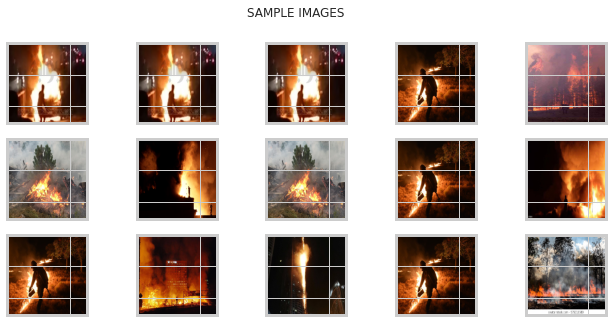

In [20]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(12)], (255,255)))/255.);
plt.show();

In [21]:
#get an image
img = read_img(df['file'][4],(255,255))

In [22]:
#mask
image_mask = create_mask_for_plant(img)

In [23]:
#segmentation
image_segmented = segment_image(img)

In [24]:
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


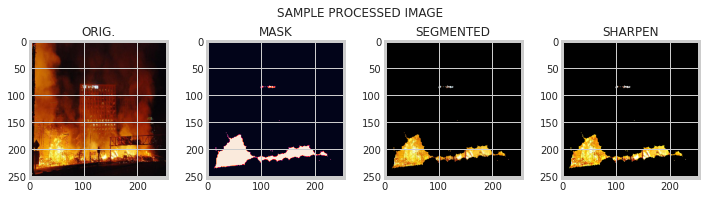

In [25]:
#fig, ax = plt.subplots(1, 4, figsize=(10, 5));
#plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
#plt.tight_layout(1)
#get an image
img = read_img(df['file'][10],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);

In [26]:
ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)

Text(0.5, 1.0, 'ORIG.')

Text(0.5, 1.0, 'MASK')

Text(0.5, 1.0, 'SEGMENTED')

Text(0.5, 1.0, 'SHARPEN')

In [27]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

100it [00:04, 24.36it/s]


In [28]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)


Train Image Shape:  (100, 255, 255, 3)
Train Image Size:  19507500


In [29]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])


FIRE IMAGES ON TRAINING DATA:  37
NON-FIRE IMAGES ON TRAINING DATA:  43


In [30]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

1/1 [==============================] - 5s 5s/step


In [31]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (80, 2048)
Train Size:  163840
Validation Shape:  (20, 2048)
Validation Size:  40960


In [32]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
3/3 [==============================] - 1s 9ms/step - loss: 0.6891 - accuracy: 0.5375
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 0.6636 - accuracy: 0.5375
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.6414 - accuracy: 0.8250
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.6168 - accuracy: 0.8250
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5856 - accuracy: 0.7750
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5780 - accuracy: 0.6750
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5396 - accuracy: 0.7750
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.5254 - accuracy: 0.8000
Epoch 9/100
3/3 [==============================] - 0s 9ms/step - loss: 0.4967 - accuracy: 0.8500
Epoch 10/100
3/3 [==============================] - 0s 10ms/step - loss: 0.4665 - accuracy: 0.8375
Epoch 11/100
3/3 [======

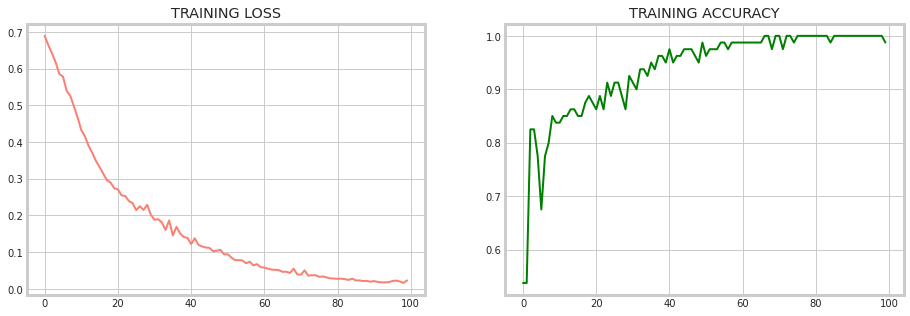

In [33]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);


In [34]:
#predict the validation data
# predict_x=model.predict(X_test) 
# classes_x=np.argmax(predict_x,axis=1)
predict_x = model.predict(bf_train_val)
predictions = np.argmax(predict_x,axis=1)



In [35]:
print(classification_report(y_val, predictions))

confusion_mat = confusion_matrix(y_val, predictions)


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        13
           1       0.00      0.00      0.00         7

    accuracy                           0.65        20
   macro avg       0.33      0.50      0.39        20
weighted avg       0.42      0.65      0.51        20



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
